To run the notebook make sure to install ipykernel in the environment: <br />
conda install ipykernel <br />
ipython kernel install --user --name=stellar

In [ ]:
import argparse
from utils import prepare_save_dir
from STELLAR import STELLAR
import numpy as np
import torch
import pandas as pd
import anndata
import scanpy as sc
import pickle
import sys
sys.path.append("../")
from datasets import GraphDataset, load_tonsilbe_data, load_hubmap_data

The notebook contains demo of running downsampled Tonsil/Barrett’s esophagus CODEX dataset where tonsil dataset is used as annotated dataset and Barrett’s esophagus dataset as unannotated dataset. The demo shows an example on a downsampled dataset constructed using 50% cells of the original dataset. The distance threshold for graph construction is dataset specific and here we set it to 50 as in the paper (see Fig 2h for performance with different threshold values). Datasets for running demo example can be found on [dryad](https://datadryad.org/stash/share/1OQtxew0Unh3iAdP-ELew-ctwuPTBz6Oy8uuyxqliZk). 

### Setting default parameters

In [2]:
parser = argparse.ArgumentParser(description='STELLAR')
parser.add_argument('--dataset', default='TonsilBE', help='dataset setting')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='random seed (default: 1)')
parser.add_argument('--name', type=str, default='STELLAR')
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--lr', type=float, default=1e-3) # learning rate
parser.add_argument('--wd', type=float, default=5e-2) # weight decay
parser.add_argument('--num-heads', type=int, default=13)
parser.add_argument('--num-seed-class', type=int, default=3)
parser.add_argument('--sample-rate', type=float, default=0.5) # downsample dataset by using 50% of cells
parser.add_argument('-b', '--batch-size', default=1, type=int,
                metavar='N', help='mini-batch size')
parser.add_argument('--distance_thres', default=50, type=int)# distance threshold for constructing the graph
parser.add_argument('--savedir', type=str, default='./') # output directory

In [ ]:
parser.add_argument('--use-processed-graph', type=bool, default=False) # whether to use already preprocessed graph or construct the graph 

In [ ]:
args = parser.parse_args(args=[])
args.cuda = torch.cuda.is_available()
args.device = torch.device("cuda" if args.cuda else "cpu")

STELLAR expects graph as input. This code either loads already constructed graph from TonsilBE_processed_0.5.pkl resulting in lower running time, or also runs graph construction part:

In [3]:
if args.use_processed_graph:
    labeled_X, labeled_y, unlabeled_X, labeled_edges, unlabeled_edges, inverse_dict = pickle.load(open( "./data/TonsilBE_processed_0.5.pkl", "rb" ) )
else:
    labeled_X, labeled_y, unlabeled_X, labeled_edges, unlabeled_edges, inverse_dict = load_tonsilbe_data('./data/BE_Tonsil_l3_dryad.csv', args.distance_thres, args.sample_rate)
dataset = GraphDataset(labeled_X, labeled_y, unlabeled_X, labeled_edges, unlabeled_edges)

### Training STELLAR

In [4]:
stellar = STELLAR(args, dataset)
stellar.train()
_, results = stellar.pred()

Computing METIS partitioning...
Done!
Loss: 3.834065
Loss: 3.365167
Loss: 3.198317
Loss: 2.989929
Computing METIS partitioning...
Done!
Loss: 1.632940
Loss: 1.839369
Loss: 1.738831
Loss: 1.610152
Computing METIS partitioning...
Done!
Loss: 0.855135
Loss: 1.197403
Loss: 1.104087
Loss: 1.064079
Computing METIS partitioning...
Done!
Loss: 0.455301
Loss: 0.836660
Loss: 0.802742
Loss: 0.793245
Computing METIS partitioning...
Done!
Loss: 0.883150
Loss: 0.745530
Loss: 0.682287
Loss: 0.655123
Computing METIS partitioning...
Done!
Loss: 0.533689
Loss: 0.572890
Loss: 0.543413
Loss: 0.538035
Computing METIS partitioning...
Done!
Loss: 0.420863
Loss: 0.491461
Loss: 0.491552
Loss: 0.489869
Computing METIS partitioning...
Done!
Loss: 0.410337
Loss: 0.467096
Loss: 0.458669
Loss: 0.455071
Computing METIS partitioning...
Done!
Loss: 0.487268
Loss: 0.445187
Loss: 0.435634
Loss: 0.427991
Computing METIS partitioning...
Done!
Loss: 0.375452
Loss: 0.405292
Loss: 0.427670
Loss: 0.425217
Computing METIS part

### Visualizing results

Cells are colored according to predicted cell types. Novel classes are denoted with numbers.

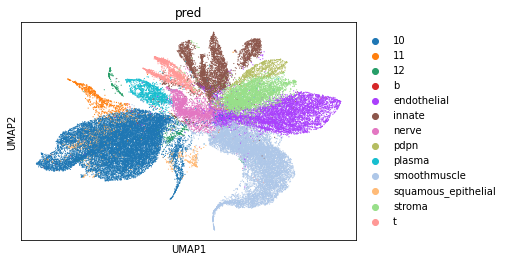

In [5]:
adata = anndata.AnnData(unlabeled_X)
results = results.astype('object')
for i in range(len(results)):
    if results[i] in inverse_dict.keys():
        results[i] = inverse_dict[results[i]]
adata.obs['pred'] = pd.Categorical(results)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['pred'], size=5)